In [1]:
using PyPlot

if isdir("ikj") == true
    rm("ikj", recursive=true)
end

mkdir("ikj")

### Homogene Transformationsmatrizen

In [2]:
RZ(θ) = [
    [cos(θ) -sin(θ) 0 0];
    [sin(θ) cos(θ) 0 0];
    [0 0 1 0];
    [0 0 0 1]
]

RX(α) = [
    [1 0 0 0]
    [0 cos(α) -sin(α) 0];
    [0 sin(α)  cos(α) 0];
    [0 0 0 1]
]

TZ(d) = [
    [1 0 0 0];
    [0 1 0 0];
    [0 0 1 d];
    [0 0 0 1]
]

TX(a) = [
    [1 0 0 a];
    [0 1 0 0];
    [0 0 1 0];
    [0 0 0 1]
]

A(θ, d, α, a) = RZ(θ) * TZ(d) * TX(a) * RX(α)

A (generic function with 1 method)

In [3]:
A(π, 1, -π, 2)

4x4 Array{Float64,2}:
 -1.0           1.22465e-16  -1.49976e-32  -2.0        
  1.22465e-16   1.0          -1.22465e-16   2.44929e-16
  0.0          -1.22465e-16  -1.0           1.0        
  0.0           0.0           0.0           1.0        

### Definition Roboter

In [4]:
A1(θ) = A(θ,0,0,2)
A2(θ) = A(θ,0,0,1)
A3(θ) = A(θ,0,0,0.75)

endeffector(θ1,θ2,θ3) = [
    2. * cos(θ1) + cos(θ1 + θ2) +  0.75 * cos(θ1 + θ2 + θ3);
    2. * sin(θ1) + sin(θ1 + θ2) +  0.75 * sin(θ1 + θ2 + θ3);
    0;
    1
]

function J(θ1, θ2, θ3)
    a = -2 * sin(θ1) - sin(θ1 + θ2) - 0.75 * sin(θ1 + θ2 + θ3)
    b = -1 * sin(θ1 + θ2) - 0.75 * sin(θ1 + θ2 + θ3)
    c = -0.75 * sin(θ1 + θ2 + θ3)
    
    d = 2 * cos(θ1) + cos(θ1 + θ2) + 0.75 * cos(θ1 + θ2 + θ3)
    e = 1 * cos(θ1 + θ2) + 0.75 * cos(θ1 + θ2 + θ3)
    f = 0.75 * cos(θ1 + θ2 + θ3)

    [ [a b c]; [d e f]]
end

Jinv(θ1, θ2, θ3) = pinv(J(θ1, θ2, θ3))

normalize(x) = x/norm(x)

normalize (generic function with 1 method)

### Direkte Kinematik

In [5]:
function ForwardKinematics(q)
    base = [0;0;0;1]
    
    θ1 = q[1]
    θ2 = q[2]
    θ3 = q[3]
    
    p1 = A1(θ1) * base
    p2 = A1(θ1) * A2(θ2) * base
    p3 = A1(θ1) * A2(θ2) * A3(θ3) * base
    
    [p1 p2 p3]
end

ForwardKinematics (generic function with 1 method)

### Inverse Kinematik

In [6]:
function InverseKinematics(goal, q)
    base = [0;0;0;1]
    δ = 0.01
    e = A1(q[1]) * A2(q[2]) * A3(q[3]) * base
    j = Jinv(q[1], q[2], q[3])
    d = reshape(goal - e[1:2], 2,1)
    step = j * d
    dist = sqrt(step[1] * step[1] + step[2] * step[2])
    if dist > δ
        step = normalize(step) * δ
    end
    q = q + step'
    q
end

InverseKinematics (generic function with 1 method)

### Plot Funktionen

In [7]:
function PlotRoboter(coords, goal)
    fig = figure(figsize=(8,5))
    xlim(-4,4)
    ylim(-1,4)
    xticks([])
    yticks([])
    
    plot([0,           coords[1,1]], [0,           coords[2,1]], color="red",    lw = 5.0)
    plot([coords[1,1], coords[1,2]], [coords[2,1], coords[2,2]], color="green",  lw = 5.0)
    plot([coords[1,2], coords[1,3]], [coords[2,2], coords[2,3]], color="blue",   lw = 5.0)
    plot([goal[1]-0.1, goal[1]+0.1], [goal[2]-0.1, goal[2]+0.1], color="purple", lw = 1.0)
    plot([goal[1]-0.1, goal[1]+0.1], [goal[2]+0.1, goal[2]-0.1], color="purple", lw = 1.0)
    fig
end

PlotRoboter (generic function with 1 method)

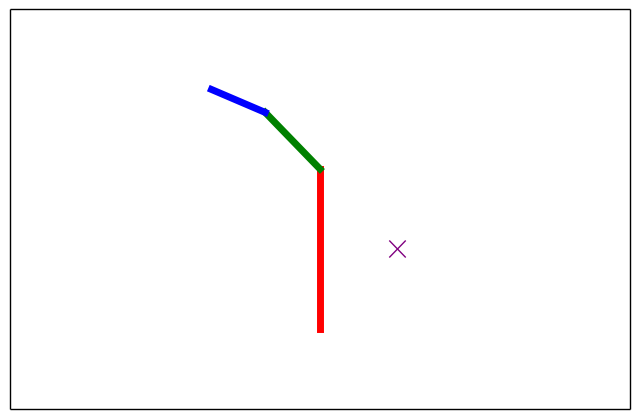

In [8]:
coords = ForwardKinematics([π/2,π/4,π/8])
PlotRoboter(coords, [1; 1])

In [11]:
q = [π/2 0.01 0.01]
goal = [1.0; 1.5]
j = 0
ϵ = 0.1

er = 1.0

ioff()
while er > ϵ
    j = j + 1
    q = InverseKinematics(goal, q)
    coords = ForwardKinematics(q)
    fig = PlotRoboter(coords ,goal)
    savefig("ikj/robot_$(j-1).png", bbox_inches="tight")
    close(fig)
    dx = goal[1] - coords[1,3]
    dy = goal[2] - coords[2,3]
    er = sqrt(dx*dx + dy*dy)
end

er = 1
goal = [0.0; 2.0]
while er > ϵ
    j = j + 1
    q = InverseKinematics(goal, q)
    coords = ForwardKinematics(q)
    fig = PlotRoboter(coords ,goal)
    savefig("ikj/robot_$(j-1).png", bbox_inches="tight")
    close(fig)
    dx = goal[1] - coords[1,3]
    dy = goal[2] - coords[2,3]
    er = sqrt(dx*dx + dy*dy)
end

er = 1
goal = [-1.0; 1.5]
while er > ϵ
    j = j + 1
    q = InverseKinematics(goal, q)
    coords = ForwardKinematics(q)
    fig = PlotRoboter(coords ,goal)
    savefig("ikj/robot_$(j-1).png", bbox_inches="tight")
    close(fig)
    dx = goal[1] - coords[1,3]
    dy = goal[2] - coords[2,3]
    er = sqrt(dx*dx + dy*dy)
end

ion()